In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold


In [2]:

# df_TagDesc = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv')

# df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_1o2.csv')
# df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_2o2.csv')
# # Concatenate (union) the dataframes
# df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)

df_All = pd.read_csv(r'C:\Users\austinsh\Project-OptiC4\III Models\3 Model STEAM - FC55569\5 Preprocessing - Slecected Features\Merge Data\merged_data.csv')

print(df_All.head())


                  Date  425_pct_Al     Al2O3  C4_pct_Eth  C4_pct_H2O  \
0  2012-05-08 23:00:00    6.254940  12.14350    2.006150    20.98780   
1  2012-05-09 06:00:00    6.254725  12.10140    2.015650    21.00625   
2  2012-05-09 07:00:00    6.254475  12.05325    2.026510    21.02730   
3  2012-05-09 08:00:00    6.254410  12.04120    2.029225    21.03255   
4  2012-05-09 09:00:00    6.254350  12.02915    2.031940    21.03785   

   C4_pct_Hex  FC55569   DI55102   DI55152   DI55580      FC55003   FC55576  \
0    0.534483      0.0  0.835875  0.878343  0.871840  2062.630000  5.927110   
1    0.536844      0.0  0.857498  0.918667  0.938666  2208.816667  8.012427   
2    0.539542      0.0  0.857498  0.918667  0.938666  2208.816667  8.012427   
3    0.540216      0.0  0.857498  0.918667  0.938666  2208.816667  8.012427   
4    0.540890      0.0  0.863447  0.924006  0.945967  2222.720000  7.198467   

   FFC55555    LC90366   PI55020  
0       0.0  82.673400 -3.849210  
1       0.0  82.653467

In [3]:
# Set max columns to display
pd.set_option('display.max_columns', None)

In [4]:
# # # List of columns to exclude from the XGboost feature selection results
# exclude_columns = [
#                     'M_Value',
#                     'HydWtr_pct_Ammonia',
#                     'HydWtr_Na2O',

#                     'PI55004',
#                     'Decanol',
#                     'LC55557',
#                     'LC52572',
#                     'LC55568',
#                     'LC90368',
#                     'LC55553',

#                     'TC55552',
#                     'FC55009',
#                     'TC55555',
#                     'FC55552',

#                     'FFC55553', # Reiterating within this run, since it was the only one found.

#                     # Should have processed these out earlier, but was assuming some Butanol as an adjuster
#                     # # FFC55555 is s better predicter according to the XGB-FS
#                     'Butanol',
#                     'TI55021',
#                     'TI40050'

# #                  'Date',
# #                  'C4_pct_Hex', 'HydWtr_Na2O',
# #                  'TC55555'  
#                    ]

# # # Create a new DataFrame without the excluded columnsd
# df_All = df_All.drop(columns=exclude_columns)

In [5]:
df_All.columns

Index(['Date', '425_pct_Al', 'Al2O3', 'C4_pct_Eth', 'C4_pct_H2O', 'C4_pct_Hex',
       'FC55569', 'DI55102', 'DI55152', 'DI55580', 'FC55003', 'FC55576',
       'FFC55555', 'LC90366', 'PI55020'],
      dtype='object')

In [6]:
# df_All = df_All[df_All['Date'] > '2020-06-15 00:00:00']

In [7]:
# df_All.drop('Date', axis=1, inplace=True)




In [8]:
print(df_All.describe())

         425_pct_Al         Al2O3    C4_pct_Eth    C4_pct_H2O    C4_pct_Hex  \
count  77594.000000  77594.000000  77594.000000  77594.000000  77594.000000   
mean       6.121071     11.285251      1.267564     20.825445      0.450233   
std        0.304648      0.601248      0.857618      2.846999      0.219702   
min        4.325245      9.475050      0.013766      7.714985      0.000006   
25%        5.986446     10.900800      0.646014     18.461612      0.330000   
50%        6.130208     11.434425      1.177652     20.842125      0.429405   
75%        6.275129     11.672650      1.644926     22.998037      0.529739   
max        7.776060     12.885850     13.416750     34.216850      2.833645   

            FC55569       DI55102       DI55152       DI55580       FC55003  \
count  77594.000000  77594.000000  77594.000000  77594.000000  77594.000000   
mean    5388.942198      0.946001      0.941385      0.996515   4807.275514   
std     2552.104099      0.054662      0.037676    

In [9]:
# Assuming your data is in filtered_df and you want to predict 'target_column_name'
X = df_All.drop(['FC55569', 'Date'], axis=1)  # Replace 'target_column_name' with your target column's name
y = df_All['FC55569']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate=0.05,
    n_estimators=800,
    max_depth=10,
    subsample=0.6,
    colsample_bytree=1,
    gamma=0,
    alpha=0.1,
    reg_lambda=1.5,
    colsample_bylevel=0.8,
    colsample_bynode=0.7
)
xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
# Predict on training data
y_train_pred = xgb_model.predict(X_train)

# Evaluate the model on training data
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on Training Data: {mse_train}")



# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Data: {mse}")

rmse_train = np.sqrt(mse_train)
print(f"Root Mean Squared Error on Training Data: {rmse_train}")


rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on the Testing Data: {rmse}")

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f"R-squared value on Training Data:: {r2_train:.2f}")


# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared value on the Testing Data: {r2:.2f}")

current_features = X.columns.tolist()

# Calculate Adjusted R-squared
def adjusted_r2(r2, n, k):
    """
    Compute the adjusted R^2 from R^2, number of samples (n) and number of predictors (k).
    
    Args:
    - r2 (float): R^2 value
    - n (int): number of samples
    - k (int): number of predictors

    Returns:
    - float: adjusted R^2 value
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)


adj_r2 = adjusted_r2(r2, len(y_test), len(current_features))

print(f"Adjusted R^2 value: {adj_r2}")

Mean Squared Error on Training Data: 80.28261681833855
Mean Squared Error on the Testing Data: 2933.6403256237977
Root Mean Squared Error on Training Data: 8.960056741915118
Root Mean Squared Error on the Testing Data: 54.163090067164724
R-squared value on Training Data:: 1.00
R-squared value on the Testing Data: 1.00
Adjusted R^2 value: 0.9995412790475187


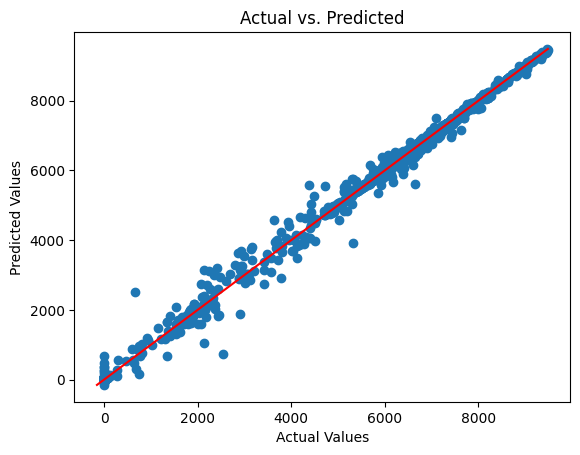

In [13]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')

# Calculate the min and max values across both y_test and y_pred
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))

# Plot the red 1:1 line
plt.plot([min_val, max_val], [min_val, max_val], color='red')  # 1:1 line

plt.show()


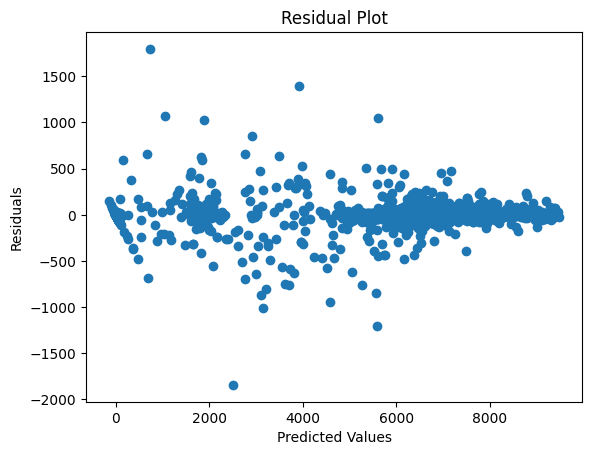

In [14]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [15]:
num_rows = df_All.shape[0]

splits = num_rows//10000

if splits < 5:
    splits = 5

In [16]:
# Define the K-fold cross validator
kfold = KFold(n_splits=splits, shuffle=True, random_state=42)

# Perform K-fold cross-validation
scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# Take the square root of the scores to get the RMSE
rmse_scores = np.sqrt(-scores)

# Print out the results
print(f'Scores for each fold are: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard deviation of RMSE: {np.std(rmse_scores)}')

Scores for each fold are: [57.20094235 55.07095021 52.15053695 50.28134749 52.73857892 50.21860406
 54.32045897]
Average RMSE: 53.14020270589059
Standard deviation of RMSE: 2.3742646691544893


In [17]:
df_All.columns

Index(['Date', '425_pct_Al', 'Al2O3', 'C4_pct_Eth', 'C4_pct_H2O', 'C4_pct_Hex',
       'FC55569', 'DI55102', 'DI55152', 'DI55580', 'FC55003', 'FC55576',
       'FFC55555', 'LC90366', 'PI55020'],
      dtype='object')

In [18]:
import pickle

# Assuming your model is trained and stored in xgb_model as shown in your code

# Save the model to disk
filename = 'STEAM_xgb_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

print("Model saved successfully.")


Model saved successfully.
